In [ ]:
#!pip install -U imbalanced-learn
#!pip install -U scikit-learn

In [ ]:
! pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=fda5aaec48dcd81a40e903d75b12a75d7b9e22474a2b165b13b7fd31471aa104
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
import time
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, \
                                      NaiveBayes, RandomForestClassifier, GBTClassifier, \
                                      MultilayerPerceptronClassifier, LinearSVC, \
                                      OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [ ]:
from pyspark.sql import SparkSession
# Initialize Spark session
spark = SparkSession.builder.appName("IntrusionDetection").getOrCreate()

In [ ]:
start = time.time()

In [ ]:
features = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
            "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
            "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
            "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
            "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate",
            "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count",
            "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
            "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
            "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]

In [ ]:
dataset = spark.read.csv("/content/corrected", inferSchema=True, header=False)

In [ ]:
dataset = dataset.toDF(*features)

In [ ]:
from pyspark.sql.functions import regexp_replace
dataset = dataset.withColumn("label", regexp_replace("label", "\.", ""))

In [ ]:
print("Dataset sizes: {row} samples, {cols} features".format(row=dataset.count(), cols=len(dataset.columns)))

Dataset sizes: 311029 samples, 42 features


In [ ]:
def find_categorical_columns(df):
    categorical_columns = [col for (col, data_type) in df.dtypes if data_type == "string"]
    return categorical_columns

In [ ]:
# Identify categorical columns in the DataFrame
categorical_columns = find_categorical_columns(dataset)

# Print the result
print("Categorical Columns:", categorical_columns)

Categorical Columns: ['protocol_type', 'service', 'flag', 'label']


In [ ]:
# Check the schema and data
dataset.printSchema()
dataset.show()

root
 |-- duration: integer (nullable = true)
 |-- protocol_type: string (nullable = true)
 |-- service: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- src_bytes: integer (nullable = true)
 |-- dst_bytes: integer (nullable = true)
 |-- land: integer (nullable = true)
 |-- wrong_fragment: integer (nullable = true)
 |-- urgent: integer (nullable = true)
 |-- hot: integer (nullable = true)
 |-- num_failed_logins: integer (nullable = true)
 |-- logged_in: integer (nullable = true)
 |-- num_compromised: integer (nullable = true)
 |-- root_shell: integer (nullable = true)
 |-- su_attempted: integer (nullable = true)
 |-- num_root: integer (nullable = true)
 |-- num_file_creations: integer (nullable = true)
 |-- num_shells: integer (nullable = true)
 |-- num_access_files: integer (nullable = true)
 |-- num_outbound_cmds: integer (nullable = true)
 |-- is_host_login: integer (nullable = true)
 |-- is_guest_login: integer (nullable = true)
 |-- count: integer (nullable = true

In [ ]:
categorical_features = ["protocol_type", "service", "flag"]
indexers = [StringIndexer(inputCol=column, outputCol=column + "_num") for column in categorical_features]

In [ ]:
indexers

[StringIndexer_679397aca4fa,
 StringIndexer_c031d5eb735a,
 StringIndexer_aeef2c685ff0]

In [ ]:
indexers.append(StringIndexer(inputCol="label", outputCol="label_num"))
pipeline = Pipeline(stages=indexers)
dataset = pipeline.fit(dataset).transform(dataset)

In [ ]:
dataset.show()

+--------+-------------+--------+----+---------+---------+----+--------------+------+---+-----------------+---------+---------------+----------+------------+--------+------------------+----------+----------------+-----------------+-------------+--------------+-----+---------+-----------+---------------+-----------+---------------+-------------+-------------+------------------+--------------+------------------+----------------------+----------------------+---------------------------+---------------------------+--------------------+------------------------+--------------------+------------------------+-------------+-----------------+-----------+--------+---------+
|duration|protocol_type| service|flag|src_bytes|dst_bytes|land|wrong_fragment|urgent|hot|num_failed_logins|logged_in|num_compromised|root_shell|su_attempted|num_root|num_file_creations|num_shells|num_access_files|num_outbound_cmds|is_host_login|is_guest_login|count|srv_count|serror_rate|srv_serror_rate|rerror_rate|srv_rerror_ra

In [ ]:
exclude_list = categorical_features + ["label", "label_num"]
# print("Exclude list:")
print(exclude_list)

['protocol_type', 'service', 'flag', 'label', 'label_num']


In [ ]:
numerical_cols = [col for col in dataset.columns if col not in exclude_list]
print(numerical_cols)

['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'protocol_type_num', 'service_num', 'flag_num']


In [ ]:
df_assembler = VectorAssembler(inputCols=numerical_cols, outputCol="features")
dataset = df_assembler.transform(dataset)
dataset.printSchema()

root
 |-- duration: integer (nullable = true)
 |-- protocol_type: string (nullable = true)
 |-- service: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- src_bytes: integer (nullable = true)
 |-- dst_bytes: integer (nullable = true)
 |-- land: integer (nullable = true)
 |-- wrong_fragment: integer (nullable = true)
 |-- urgent: integer (nullable = true)
 |-- hot: integer (nullable = true)
 |-- num_failed_logins: integer (nullable = true)
 |-- logged_in: integer (nullable = true)
 |-- num_compromised: integer (nullable = true)
 |-- root_shell: integer (nullable = true)
 |-- su_attempted: integer (nullable = true)
 |-- num_root: integer (nullable = true)
 |-- num_file_creations: integer (nullable = true)
 |-- num_shells: integer (nullable = true)
 |-- num_access_files: integer (nullable = true)
 |-- num_outbound_cmds: integer (nullable = true)
 |-- is_host_login: integer (nullable = true)
 |-- is_guest_login: integer (nullable = true)
 |-- count: integer (nullable = true

In [ ]:
from pyspark.sql.functions import col
# List of string columns to drop
string_columns_to_drop = ['protocol_type', 'service', 'flag', 'label']

# Drop the string columns
dataset = dataset.select([col(column) for column in dataset.columns if column not in string_columns_to_drop])

In [ ]:
dataset.show()

+--------+---------+---------+----+--------------+------+---+-----------------+---------+---------------+----------+------------+--------+------------------+----------+----------------+-----------------+-------------+--------------+-----+---------+-----------+---------------+-----------+---------------+-------------+-------------+------------------+--------------+------------------+----------------------+----------------------+---------------------------+---------------------------+--------------------+------------------------+--------------------+------------------------+-----------------+-----------+--------+---------+--------------------+
|duration|src_bytes|dst_bytes|land|wrong_fragment|urgent|hot|num_failed_logins|logged_in|num_compromised|root_shell|su_attempted|num_root|num_file_creations|num_shells|num_access_files|num_outbound_cmds|is_host_login|is_guest_login|count|srv_count|serror_rate|srv_serror_rate|rerror_rate|srv_rerror_rate|same_srv_rate|diff_srv_rate|srv_diff_host_rate

In [ ]:
train_set, test_set = dataset.randomSplit([0.90, 0.10], seed=2019)
print("Training set Count: " + str(train_set.count()))
print("Test set Count: " + str(test_set.count()))

Training set Count: 279907
Test set Count: 31122


In [ ]:
train_set.printSchema()

root
 |-- duration: integer (nullable = true)
 |-- src_bytes: integer (nullable = true)
 |-- dst_bytes: integer (nullable = true)
 |-- land: integer (nullable = true)
 |-- wrong_fragment: integer (nullable = true)
 |-- urgent: integer (nullable = true)
 |-- hot: integer (nullable = true)
 |-- num_failed_logins: integer (nullable = true)
 |-- logged_in: integer (nullable = true)
 |-- num_compromised: integer (nullable = true)
 |-- root_shell: integer (nullable = true)
 |-- su_attempted: integer (nullable = true)
 |-- num_root: integer (nullable = true)
 |-- num_file_creations: integer (nullable = true)
 |-- num_shells: integer (nullable = true)
 |-- num_access_files: integer (nullable = true)
 |-- num_outbound_cmds: integer (nullable = true)
 |-- is_host_login: integer (nullable = true)
 |-- is_guest_login: integer (nullable = true)
 |-- count: integer (nullable = true)
 |-- srv_count: integer (nullable = true)
 |-- serror_rate: double (nullable = true)
 |-- srv_serror_rate: double (nul

In [ ]:
train_set.show()

+--------+---------+---------+----+--------------+------+---+-----------------+---------+---------------+----------+------------+--------+------------------+----------+----------------+-----------------+-------------+--------------+-----+---------+-----------+---------------+-----------+---------------+-------------+-------------+------------------+--------------+------------------+----------------------+----------------------+---------------------------+---------------------------+--------------------+------------------------+--------------------+------------------------+-----------------+-----------+--------+---------+--------------------+
|duration|src_bytes|dst_bytes|land|wrong_fragment|urgent|hot|num_failed_logins|logged_in|num_compromised|root_shell|su_attempted|num_root|num_file_creations|num_shells|num_access_files|num_outbound_cmds|is_host_login|is_guest_login|count|srv_count|serror_rate|srv_serror_rate|rerror_rate|srv_rerror_rate|same_srv_rate|diff_srv_rate|srv_diff_host_rate

In [ ]:
test_set.show()

+--------+---------+---------+----+--------------+------+---+-----------------+---------+---------------+----------+------------+--------+------------------+----------+----------------+-----------------+-------------+--------------+-----+---------+-----------+---------------+-----------+---------------+-------------+-------------+------------------+--------------+------------------+----------------------+----------------------+---------------------------+---------------------------+--------------------+------------------------+--------------------+------------------------+-----------------+-----------+--------+---------+--------------------+
|duration|src_bytes|dst_bytes|land|wrong_fragment|urgent|hot|num_failed_logins|logged_in|num_compromised|root_shell|su_attempted|num_root|num_file_creations|num_shells|num_access_files|num_outbound_cmds|is_host_login|is_guest_login|count|srv_count|serror_rate|srv_serror_rate|rerror_rate|srv_rerror_rate|same_srv_rate|diff_srv_rate|srv_diff_host_rate

In [ ]:
# Train a decision tree classifier
dt_classifier = DecisionTreeClassifier(labelCol="label_num", featuresCol="features",  maxBins=70)
pipeline = Pipeline(stages=[dt_classifier])
model = pipeline.fit(train_set.rdd.toDF())

In [ ]:
# Make predictions on the testing data
predictions = model.transform(test_set)

In [ ]:
# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label_num", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9447014973330763


In [ ]:
# SHAP Explanation
# Convert Spark DataFrame to Pandas DataFrame
pandas_df = test_set.toPandas()

In [ ]:
pandas_df

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,protocol_type_num,service_num,flag_num,label_num,features
0,0,0,0,0,0,0,0,0,0,0,...,0.00,0.00,0.00,0.02,0.33,1.0,7.0,1.0,16.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,0,0,0,0,0,0,0,0,0,0,...,0.00,0.00,0.00,0.06,0.60,1.0,7.0,1.0,16.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,0,0,0,0,0,0,0,0,0,0,...,0.00,0.00,0.00,0.11,0.78,1.0,7.0,1.0,16.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,0,0,0,0,0,0,0,0,0,0,...,0.00,0.00,0.00,0.05,1.00,1.0,7.0,1.0,16.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,0,0,0,0,0,0,0,0,0,0,...,0.00,0.00,0.00,0.11,1.00,1.0,7.0,1.0,16.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31117,8088,0,15,0,0,0,0,0,0,0,...,0.00,0.65,0.51,0.01,0.02,1.0,8.0,0.0,12.0,"(8088.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
31118,8092,0,15,0,0,0,0,0,0,0,...,0.00,0.65,0.51,0.01,0.02,1.0,8.0,0.0,12.0,"(8092.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
31119,8224,0,15,0,0,0,0,0,0,0,...,0.00,0.77,0.82,0.01,0.03,1.0,8.0,0.0,12.0,"(8224.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
31120,42689,0,0,0,0,0,0,0,0,0,...,0.01,0.04,0.01,0.00,0.01,1.0,3.0,8.0,1.0,"(42689.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."


In [ ]:
# Assuming 'df' is your DataFrame and 'column_name' is the column for which you want to find unique values
unique_values = pandas_df['label_num'].unique()

# Print or use the unique values
print(unique_values)

[16. 10.  1. 14.  2. 18. 11.  7. 13. 12. 19. 15. 22.  8. 20.  5. 26.  3.
 24.  0. 17. 25.  9.  4. 23. 30. 21.  6.]


In [ ]:
X = pandas_df[numerical_cols]

In [ ]:
X

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,protocol_type_num,service_num,flag_num
0,0,0,0,0,0,0,0,0,0,0,...,0.11,0.02,0.00,0.00,0.00,0.02,0.33,1.0,7.0,1.0
1,0,0,0,0,0,0,0,0,0,0,...,0.10,0.02,0.00,0.00,0.00,0.06,0.60,1.0,7.0,1.0
2,0,0,0,0,0,0,0,0,0,0,...,0.08,0.02,0.00,0.00,0.00,0.11,0.78,1.0,7.0,1.0
3,0,0,0,0,0,0,0,0,0,0,...,0.04,0.01,0.00,0.00,0.00,0.05,1.00,1.0,7.0,1.0
4,0,0,0,0,0,0,0,0,0,0,...,0.03,0.01,0.00,0.00,0.00,0.11,1.00,1.0,7.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31117,8088,0,15,0,0,0,0,0,0,0,...,0.02,0.00,0.00,0.65,0.51,0.01,0.02,1.0,8.0,0.0
31118,8092,0,15,0,0,0,0,0,0,0,...,0.02,0.00,0.00,0.65,0.51,0.01,0.02,1.0,8.0,0.0
31119,8224,0,15,0,0,0,0,0,0,0,...,0.02,0.00,0.00,0.77,0.82,0.01,0.03,1.0,8.0,0.0
31120,42689,0,0,0,0,0,0,0,0,0,...,0.06,0.02,0.01,0.04,0.01,0.00,0.01,1.0,3.0,8.0


In [ ]:
! pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 5.2 MB/s eta 0:00:00


In [ ]:
! pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=5768e5886391c8c3472b7b0a15e5c56993ab48a46235cb5a7fb77506d0ce009a
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
# Get feature importances
feature_importances = model.stages[0].featureImportances

# Display feature importances
print("Feature Importances:")
for i, importance in enumerate(feature_importances):
    print(f"{numerical_cols[i]}: {importance}")

Feature Importances:
duration: 0.06014261120985329
src_bytes: 0.03417887141656277
dst_bytes: 0.0
land: 0.0
wrong_fragment: 0.0
urgent: 0.0
hot: 0.0
num_failed_logins: 0.0
logged_in: 0.0
num_compromised: 0.011468818668943781
root_shell: 0.0
su_attempted: 0.0
num_root: 0.0
num_file_creations: 0.0
num_shells: 0.0
num_access_files: 0.0
num_outbound_cmds: 0.0
is_host_login: 0.0
is_guest_login: 0.0
count: 0.01060903890046044
srv_count: 2.0098284123922506e-05
serror_rate: 0.0
srv_serror_rate: 0.0
rerror_rate: 0.0
srv_rerror_rate: 0.0
same_srv_rate: 0.2827414525056198
diff_srv_rate: 0.02017952338280758
srv_diff_host_rate: 0.0004932426997604368
dst_host_count: 0.0
dst_host_srv_count: 0.0013470440418296872
dst_host_same_srv_rate: 0.0
dst_host_diff_srv_rate: 0.0
dst_host_same_src_port_rate: 0.0
dst_host_srv_diff_host_rate: 0.0
dst_host_serror_rate: 0.0
dst_host_srv_serror_rate: 0.0
dst_host_rerror_rate: 0.0
dst_host_srv_rerror_rate: 0.0
protocol_type_num: 0.0
service_num: 0.5788192988900384
flag_

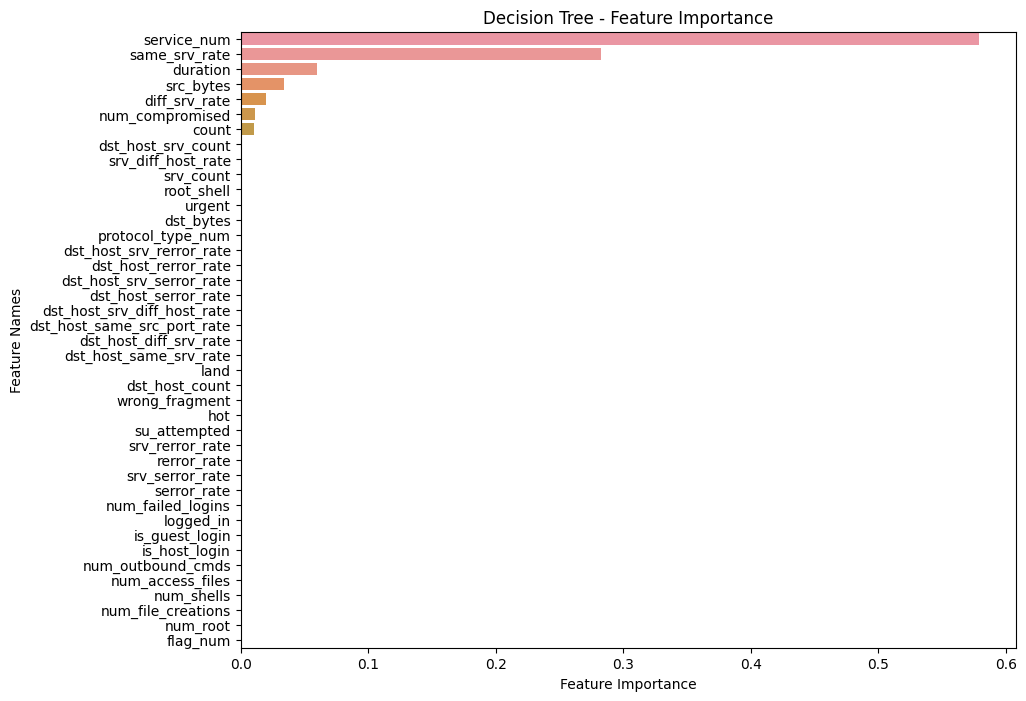

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
# Plot feature importances
def plot_feature_importances(importances, names, model_type='Random Forest'):
    feature_importance = np.array(importances)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(model_type + ' - Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

# Convert feature importances to a NumPy array
importances_array = feature_importances.toArray()

# Plot feature importances
plot_feature_importances(importances_array, numerical_cols, model_type='Decision Tree')

# Show the plot
plt.show()

In [ ]:
import shap
# Explain the model using SHAP
explainer = shap.TreeExplainer(model.stages[0])

In [ ]:
shap_values = explainer.shap_values(X, check_additivity=False)

In [ ]:
import numpy as np
# Summarize the feature importance
feature_importance = np.abs(shap_values).mean(axis=0)
print("Feature Importance:", feature_importance)

Feature Importance: [[0.00293369 0.00944832 0.         ... 0.         0.01346542 0.        ]
 [0.00293369 0.00944832 0.         ... 0.         0.01346542 0.        ]
 [0.00293369 0.00944832 0.         ... 0.         0.01346542 0.        ]
 ...
 [0.02572442 0.01401568 0.         ... 0.         0.02064393 0.        ]
 [0.02572442 0.01401568 0.         ... 0.         0.0216188  0.        ]
 [0.02082568 0.02927635 0.         ... 0.         0.01665799 0.        ]]


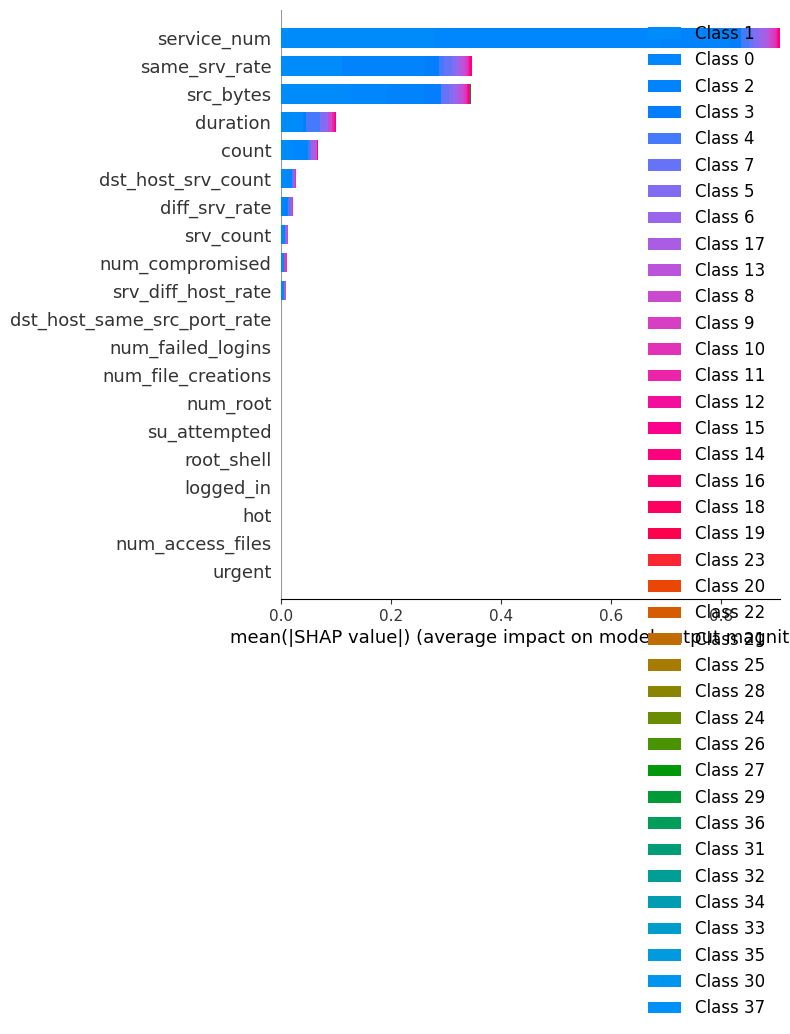

In [ ]:
# Summary plot of SHAP values
shap.summary_plot(shap_values, X, feature_names=numerical_cols)

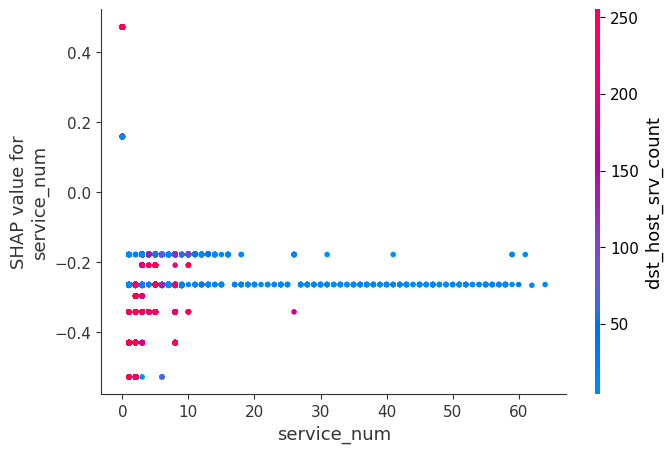

In [ ]:
# SHAP dependence plot for a specific feature
feature_of_interest = 'service_num'
shap.dependence_plot(feature_of_interest, shap_values[0], X, feature_names=numerical_cols)

In [ ]:
# Logistic Regression model
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0.8, featuresCol="features",
                        labelCol="label_num", family="multinomial")

# Decision Tree model
dt = DecisionTreeClassifier(labelCol="label_num", featuresCol="features",  maxBins=70)

# Random Forest model
rf = RandomForestClassifier(labelCol="label_num", featuresCol="features", numTrees=20, maxBins=70)

# Naive Bayes Multinomial
nb = NaiveBayes(labelCol="label_num", featuresCol="features", smoothing=1.0, modelType="multinomial")

# Linear SVM model
lsvc = LinearSVC(labelCol="label_num", featuresCol="features", maxIter=10)

# OneVsRest wrapper
ovr = OneVsRest(classifier=lsvc, labelCol="label_num", featuresCol="features")

# Multi Layer Perceptron
multilayer_perceptron = MultilayerPerceptronClassifier(labelCol="label_num", featuresCol="features",
                                                       layers=[len(numerical_cols), 10, 5, 38], blockSize=128, seed=1234)

In [ ]:
classifiers = {"Logistic Regression": lr, "Decision Tree": dt,
               "Random Forest": rf, "Naive Bayes Multinomial": nb,
               #"Linear Support Vector Machine": ovr,
               "Multilayer Perceptron": multilayer_perceptron}

In [ ]:
metrics = ["accuracy", "weightedPrecision", "weightedRecall", "f1"]

In [ ]:
print("\nModels Evaluation:")
print("{:-<30}".format(""))
for c in classifiers:
    print(c)
    # fit the model
    model = classifiers[c].fit(train_set)

    # make predictions
    predictions = model.transform(test_set)
    predictions.cache()

    # evaluate performance
    evaluator = MulticlassClassificationEvaluator(labelCol="label_num", predictionCol="prediction")

    for m in metrics:
        evaluator.setMetricName(m)
        metric = evaluator.evaluate(predictions)
        print("{name} = {value:.2f}".format(name=m, value=metric))

    print("{:-<30}".format(""))


Models Evaluation:
------------------------------
Logistic Regression
accuracy = 0.76
weightedPrecision = 0.68
weightedRecall = 0.76
f1 = 0.70
------------------------------
Decision Tree
accuracy = 0.95
weightedPrecision = 0.92
weightedRecall = 0.95
f1 = 0.93
------------------------------
Random Forest
accuracy = 0.95
weightedPrecision = 0.93
weightedRecall = 0.95
f1 = 0.94
------------------------------
Naive Bayes Multinomial
accuracy = 0.85
weightedPrecision = 0.96
weightedRecall = 0.85
f1 = 0.87
------------------------------
Multilayer Perceptron
accuracy = 0.92
weightedPrecision = 0.88
weightedRecall = 0.92
f1 = 0.90
------------------------------


In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
# Define hyperparameter grids for each model
paramGrid_lr = (ParamGridBuilder()
                .addGrid(lr.maxIter, [10, 20])
                .addGrid(lr.regParam, [0.1, 0.3])
                .addGrid(lr.elasticNetParam, [0.2, 0.8])
                .build())

paramGrid_dt = (ParamGridBuilder()
                .addGrid(dt.maxDepth, [5, 10])
                .addGrid(dt.maxBins, [66, 70])
                .build())

paramGrid_rf = (ParamGridBuilder()
                .addGrid(rf.numTrees, [10, 20])
                .addGrid(rf.maxDepth, [5, 10])
                .addGrid(rf.maxBins, [65, 70])
                .build())

paramGrid_nb = (ParamGridBuilder()
                .addGrid(nb.smoothing, [0.5, 1.5])
                .build())

# Define hyperparameter grid for OneVsRest
paramGrid_lsvc = (ParamGridBuilder()
                 .addGrid(lsvc.maxIter, [5, 10])
                 .build())

# OneVsRest wrapper
paramGrid_ovr = OneVsRest(classifier=paramGrid_lsvc, labelCol="label_num", featuresCol="features")

paramGrid_mlp = (ParamGridBuilder()
                 .addGrid(multilayer_perceptron.layers, [[len(numerical_cols), 10, 5, 38], [len(numerical_cols), 15, 10, 38]])
                 .addGrid(multilayer_perceptron.blockSize, [128, 256])
                 .build())

# Create parameter grid for tuning
param_grid = ParamGridBuilder() \
    .addGrid(lsvc.regParam, [0.01, 0.1, 1.0]) \
    .build()

In [ ]:
# Dictionary of models and their respective hyperparameter grids
models_and_params = {"Logistic Regression": (lr, paramGrid_lr),
                    "Decision Tree": (dt, paramGrid_dt),
                     "Naive Bayes": (nb, paramGrid_nb),
                     "Random Forest": (rf,paramGrid_rf),
                     #"Linear SVM": (ovr, param_grid),  # Using OneVsRest for Linear SVM
                     "Multilayer Perceptron": (multilayer_perceptron, paramGrid_mlp)
                    }

In [ ]:
# Perform hyperparameter tuning using GridSearchCV
print("\nModels Evaluation with Hyperparameter Tuning:")
print("{:-<45}".format(""))
for model_name, (model, paramGrid) in models_and_params.items():
    print(model_name)

    # Create CrossValidator
    crossval = CrossValidator(estimator=model,
                              estimatorParamMaps=paramGrid,
                              evaluator=MulticlassClassificationEvaluator(labelCol="label_num", predictionCol="prediction"),
                              numFolds=3)  # You can adjust the number of folds

    # Fit the model
    best_model = crossval.fit(train_set)

    # Make predictions
    predictions = best_model.transform(test_set)
    predictions.cache()

    # Evaluate performance
    evaluator = MulticlassClassificationEvaluator(labelCol="label_num", predictionCol="prediction")

    for m in metrics:
        evaluator.setMetricName(m)
        metric = evaluator.evaluate(predictions)
        print("{name} = {value:.2f}".format(name=m, value=metric))

    print("{:-<45}".format(""))


Models Evaluation with Hyperparameter Tuning:
---------------------------------------------
Logistic Regression
accuracy = 0.91
weightedPrecision = 0.86
weightedRecall = 0.91
f1 = 0.87
---------------------------------------------
Decision Tree
accuracy = 0.98
weightedPrecision = 0.99
weightedRecall = 0.98
f1 = 0.98
---------------------------------------------
Naive Bayes
accuracy = 0.86
weightedPrecision = 0.96
weightedRecall = 0.86
f1 = 0.87
---------------------------------------------
Random Forest
accuracy = 0.98
weightedPrecision = 0.98
weightedRecall = 0.98
f1 = 0.97
---------------------------------------------
Multilayer Perceptron
accuracy = 0.90
weightedPrecision = 0.84
weightedRecall = 0.90
f1 = 0.87
---------------------------------------------
